In [2]:
%matplotlib inline
import pandas as pd
import numpy as np

# 2017-02-23-数据集探索

# toc

- [用户浏览-数据观察和脏数据处理](#用户浏览-数据观察和脏数据处理)

# 用户浏览-数据观察和脏数据处理

### 用户浏览按照时间进行统计画图

In [3]:
data_dir = "/home/chester/data/koubei/dataset/dataset/"

In [4]:
df = pd.read_csv(data_dir +  "user_view.txt",delimiter=",",names=["user_id","shop_id","ts"], parse_dates=["ts"])

In [89]:
print "总用户浏览量为 %d," % (df.user_id.count())
print "总用户数(去重)为 %d," % (df.user_id.unique().size)
print "总商店数(去重)为 %d," % (df.shop_id.unique().size)
df_date = df.ts.dt.date
print "涉及时间长度为 %d 天,起止时间为 %s --- %s" %(df_date.unique().size,df_date.min(),df_date.max())

总用户浏览量为 5556715,
总用户数(去重)为 3683210,
总商店数(去重)为 1997,
涉及时间长度为130,起止时间为2016-06-22 --- 2016-10-31


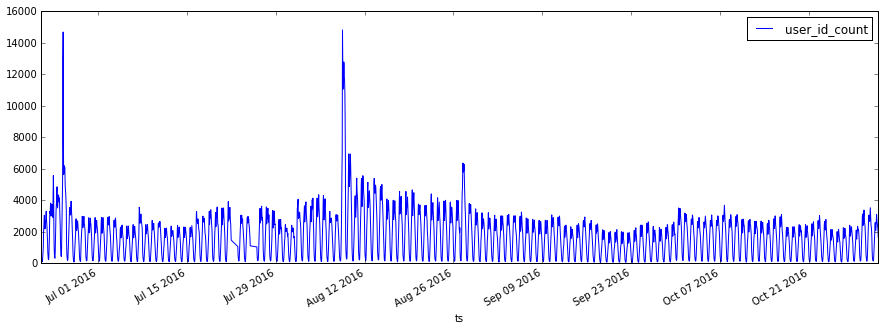

In [73]:
ts_group_df  = df.groupby("ts").agg({"user_id":np.size})
ts_group_df.rename(columns = {"user_id":"user_id_count"},inplace=True)
ts_group_df.sort_index().plot(figsize=(15,5))

下图:2016-08月份的用户浏览量展示


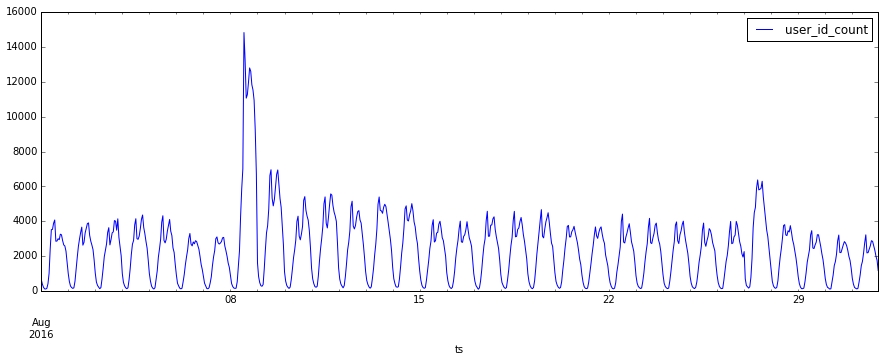

In [75]:
ts_group_df["2016-08"].plot(figsize=(15,5))
print "下图:2016-08月份的用户浏览量展示"

2016-08-08/2016-08-09 是奥运会刚开始的两天,可能主要是这个原因

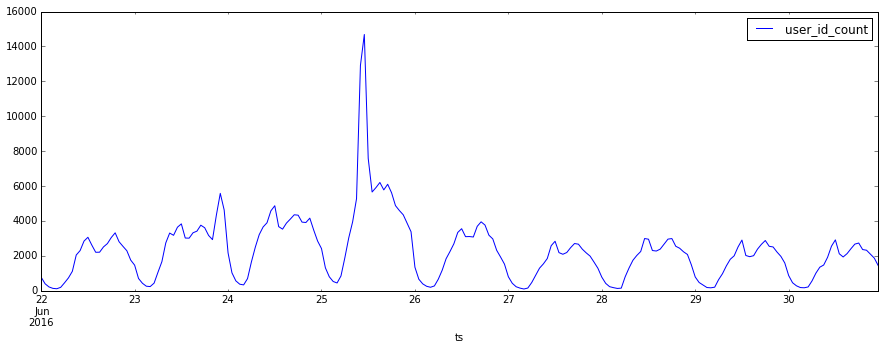

In [76]:
ts_group_df["2016-06"].plot(figsize=(15,5))

In [80]:
print "查看2016-06-24最近两三天的数据"
tmpdf = df.set_index("ts")
tmpdf["2016-06-24"].groupby("shop_id").count().sort_values("user_id",ascending=False).head(10)

查看2016-06-24最近两三天的数据


,user_id
shop_id,
298,2016
587,1578
1176,1342
1794,1314
1257,1300
1296,1284
1770,1072
465,997
1992,992


- 查看了2016-06-23/2016-06-24/2016-06-25/2016-06-26,四天的数据,23和26都正常,
- 24和25都有些shop的订单量超出其他两天的平均水平,但是在时间趋势上24并不明显,25则更为明显
- 查看了下新闻，24和25两天是台风过境，可以这样解释,24台风登陆但是波及较少地区,虽然总体量起伏不明显,但是台风波及地区的外卖需求量急剧上升,
- 而25这天，台风波及更多地区，总体需求量起伏非常明显.

### 用户浏览按照商店进行分组，按照浏览量统计和画图

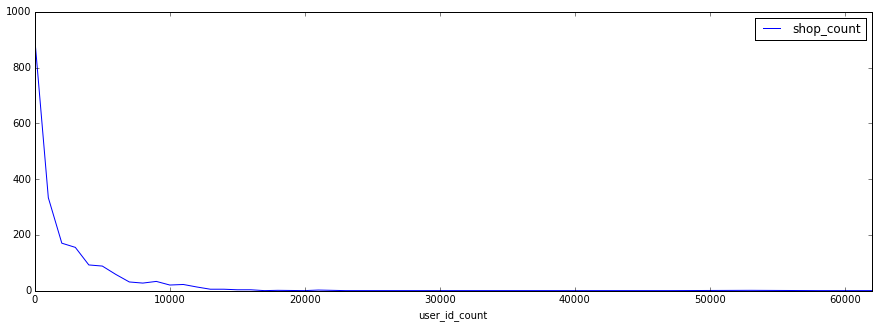

In [293]:
shop_group_df  = df.groupby("shop_id").agg({"user_id":np.size})
shop_group_df.rename(columns={"user_id":"user_id_count"},inplace=True)
shop_group_df_user_group = shop_group_df.applymap(lambda x: int(float(x)/1000)*1000)\
    .groupby("user_id_count").agg({"user_id_count":np.size}).rename(columns={"user_id_count":"shop_count"})
# print "横轴是用户浏览量,纵轴是商店数量,"
shop_group_df_user_group.plot(figsize=(15,5))

### 去除脏数据

2016年8.8和6.25两天均为较为特殊的节假日或者有异常事件发生，在分析规律的时候最好把这两个日期单独处理

说明:下图去除了2016年8.8和2016年6.25两天的数据


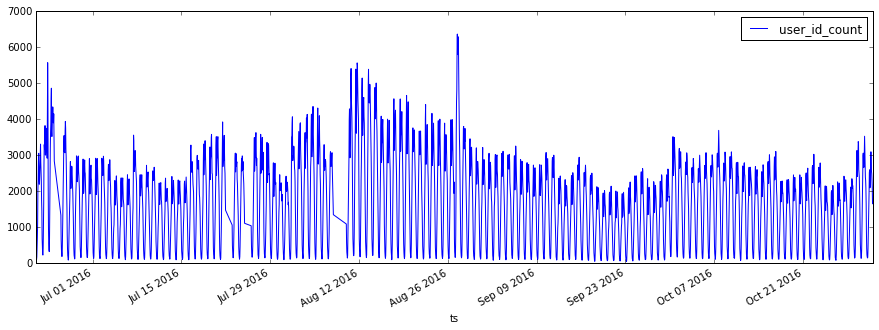

In [207]:
#ts_group_df_noexception 为去除2016年8.8和6.25两天的数据
ts_group_df_noexception = ts_group_df[ 
    (
        (ts_group_df.index < "2016-06-25") | (ts_group_df.index >= "2016-06-26")
    ) &
    (
        (ts_group_df.index < "2016-08-08") | (ts_group_df.index >= "2016-08-10")
    )
    
    
]
ts_group_df_noexception.plot(figsize=(15,5))

print "说明:下图去除了2016年8.8和2016年6.25两天的数据"

### 周统计

下图横轴为周Monday=0, Sunday=6,纵轴为该weekday的平均用户数
基本没有什么模式,从众数来看,因为众数非常平稳,虽然从均值来看周模式差别明显,但是均值并不是一个好的指标


/usr/local/lib/python2.7/dist-packages/ipykernel-4.3.1-py2.7.egg/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


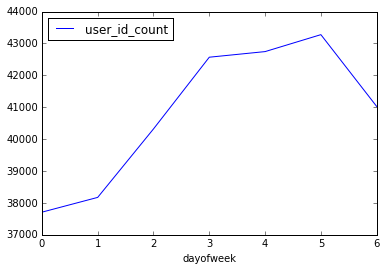

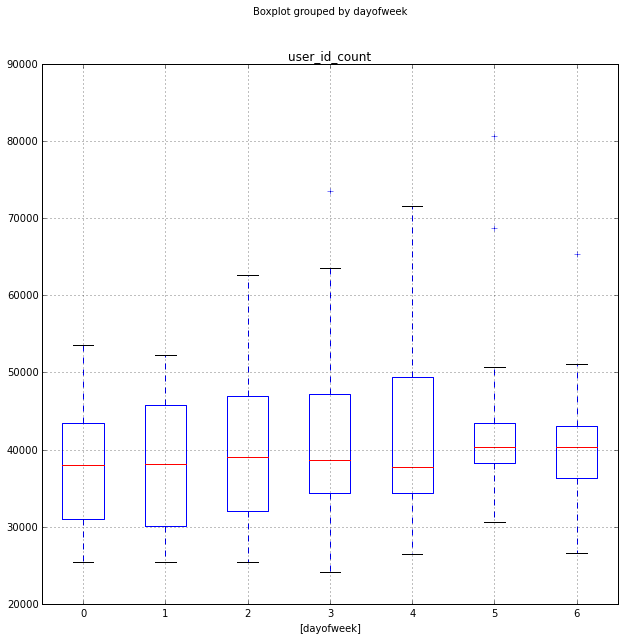

In [234]:
ts_group_df_noexception["date"] = ts_group_df_noexception.index.to_series().dt.date
date_group_df_noexception = ts_group_df_noexception.groupby("date").agg({"user_id_count":np.sum})
date_group_df_noexception.index = pd.DatetimeIndex(date_group_df_noexception.index)
date_group_df_noexception["dayofweek"] = date_group_df_noexception.index.to_series().dt.dayofweek
date_group_df_noexception.groupby("dayofweek").agg({"user_id_count":np.mean}).plot() #Monday=0, Sunday=6
date_group_df_noexception.boxplot(by="dayofweek",figsize=(10,10))
print "下图横轴为周Monday=0, Sunday=6,纵轴为该weekday的平均用户数"
print "基本没有什么模式,从众数来看,因为众数非常平稳,虽然从均值来看周模式差别明显,但是均值并不是一个好的指标"

### 月模式

下图横轴为月day,纵轴为该weekday的平均用户数,从图中可以看出,月模式受异常时间影响非常大,基本上很难分析出一些背后的模式,故这里抛弃.
另外,从纵轴来看,其均值浮动并不大,因此可以认为是无模式


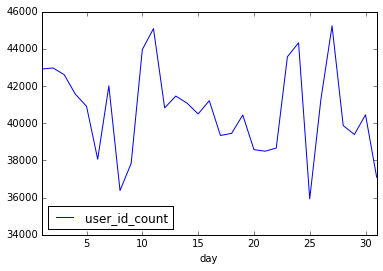

In [220]:
date_group_df_noexception["day"] = date_group_df_noexception.index.to_series().dt.day
date_group_df_noexception.groupby("day").agg({"user_id_count":np.mean}).plot() #Monday=0, Sunday=6
print "下图横轴为月day,纵轴为该weekday的平均用户数,从图中可以看出,月模式受异常时间影响非常大,基本上很难分析出一些背后的模式,故这里抛弃."
print "另外,从纵轴来看,其均值浮动并不大,因此可以认为是无模式"

### 天模式

/usr/local/lib/python2.7/dist-packages/ipykernel-4.3.1-py2.7.egg/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


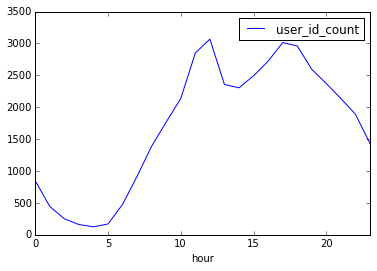

In [340]:
ts_group_df_noexception["hour"] = ts_group_df_noexception.index.to_series().dt.hour
ts_group_df_noexception.groupby("hour").agg({"user_id_count":np.mean}).plot() #Monday=0, Sunday=6

# 店模式

### 商店分级

In [320]:
#对店进行分级 3000,(总浏览量) 3000以上的为优质商店
base_shop = shop_group_df[shop_group_df.user_id_count<3000].index
premium_shop = shop_group_df[shop_group_df.user_id_count>=3000].index
# df[df.shop_id in premium_shop]
base_median = df[df.shop_id.isin(base_shop)].groupby("shop_id").agg({"user_id":np.size}).median()

premium_median = df[df.shop_id.isin(premium_shop)].groupby("shop_id").agg({"user_id":np.size}).median()

print "基本商店用户浏览量中位数%d" % (base_median)
print "优质商店浏览量中位数%d" % (premium_median)

基本商店用户浏览量中位数699
优质商店浏览量中位数5533


### 商店周模式聚类
周模式进行聚类

In [472]:
dayofweek_mode_df = df.copy()
dayofweek_mode_df["dayofweek"] = dayofweek_mode_df.ts.dt.dayofweek

shop_dayofweek_pivot_df = pd.pivot_table(dayofweek_mode_df,values="user_id",index="shop_id",columns="dayofweek",aggfunc=np.size)
shop_dayofweek_pivot_df.fillna(0,inplace=True)
shop_dayofweek_pivot_df_normalized = shop_dayofweek_pivot_df.apply(lambda x:x/x.sum(),axis=1)

从图中可以看出,周模式可以分为周五模式/周六模式/重度周一模式/轻度周一模式/均匀模式


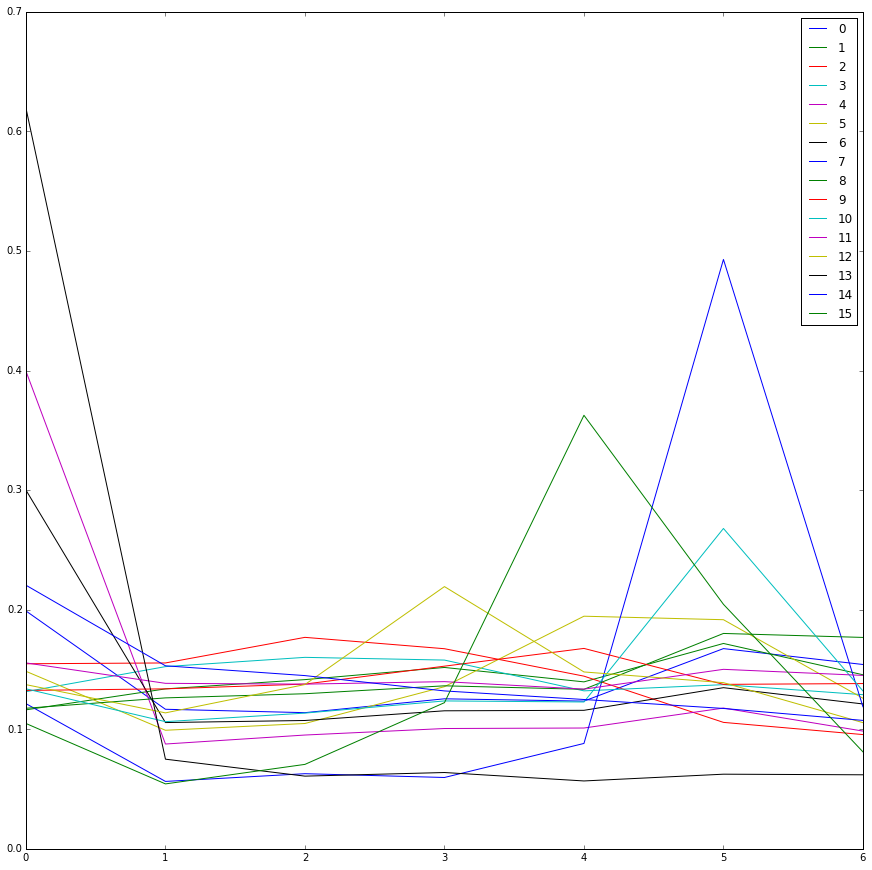

In [482]:
shop_hour_pivot_df.values
from sklearn.cluster import KMeans
cluster_handle = KMeans(n_clusters=16)
cluster_handle.fit(shop_dayofweek_pivot_df_normalized.values)
pd.DataFrame(cluster_handle.cluster_centers_).transpose().plot(figsize=(15,15))

print "从图中可以看出,周模式可以分为周五模式/周六模式/重度周一模式/轻度周一模式/均匀模式"

### 商店天模式聚类

In [446]:
shop_hour_pivot_df = pd.pivot_table(hour_mode_df,values="user_id",index="shop_id",columns="hour",aggfunc=np.size)
shop_hour_pivot_df.fillna(0,inplace=True)
shop_hour_pivot_df_normalized = shop_hour_pivot_df.apply(lambda x:x/x.sum(),axis=1)

In [460]:
shop_hour_pivot_df.values
from sklearn.cluster import KMeans
cluster_handle = KMeans(n_clusters=16)
cluster_handle.fit(shop_hour_pivot_df_normalized.values)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=16, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

从图中能明显分辨出来外卖商店的各种分类,早餐/晚餐/午餐/夜宵/以及混合类型的
假如说,早餐/晚餐/午餐/夜宵,这几种基本的时间段模式,那么单一以及混合模式应该有2**4=16种


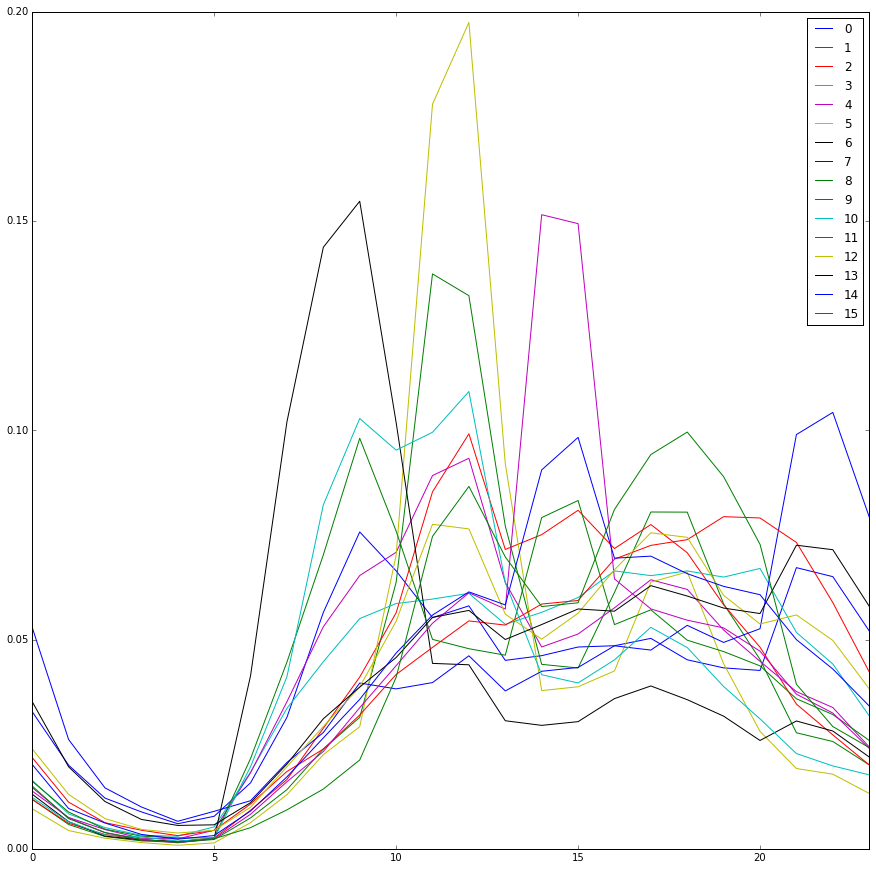

In [462]:

pd.DataFrame(cluster_handle.cluster_centers_).transpose().plot(figsize=(15,15))

print "从图中能明显分辨出来外卖商店的各种分类,早餐/晚餐/午餐/夜宵/以及混合类型的"
print "假如说,早餐/晚餐/午餐/夜宵,这几种基本的时间段模式,那么单一以及混合模式应该有2**4=16种"

### 用户对商店的重复浏览模式
可能从中挖出复购的模式

In [497]:
user_shop_repeat_view =  df.copy()
user_cnt = user_shop_repeat_view.groupby("shop_id").agg({"user_id":np.size})
unique_user_cnt = user_shop_repeat_view.groupby("shop_id").agg({"user_id":lambda x:np.size(np.unique(x))})

# user_cnt.join(unique_user_cnt,on="index")
shop_view_user_count = user_cnt.merge(unique_user_cnt, left_index=True,right_index=True)

shop_view_user_count["unique_user_rate"] = shop_view_user_count["user_id_y"]/shop_view_user_count["user_id_x"]

比例为,浏览量中,去重用户数量的比例


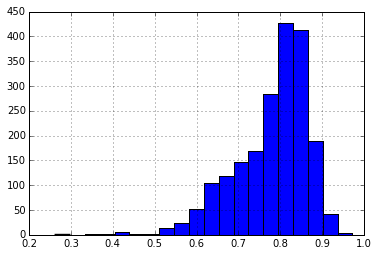

In [506]:
shop_view_user_count["unique_user_rate"].hist(bins=20)
print "比例为,浏览量中,去重用户数量的比例"

### 商店的留存描述

In [681]:

agg_cnt = lambda x:{ k:v for (k,v) in \
    pd.DataFrame(x).groupby("user_id")\
    .agg({"user_id":np.size}).groupby("user_id").agg({"user_id":np.size})["user_id"].to_dict().iteritems()
    if k<=10}

tmp_agg_cnt = user_shop_repeat_view.groupby("shop_id").agg({"user_id":agg_cnt})

shop_view_cnt_user_cnt = pd.DataFrame.from_dict(tmp_agg_cnt["user_id"].to_dict(),orient="index")
## 需修改为>=10的全部归到10上

In [694]:
shop_view_cnt_user_cnt_normalized = shop_view_cnt_user_cnt.fillna(0).apply(lambda x:x/x.sum(),axis=1)

from sklearn.cluster import KMeans
cluster_handle = KMeans(n_clusters=3)
cluster_handle.fit(shop_view_cnt_user_cnt_normalized.values)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

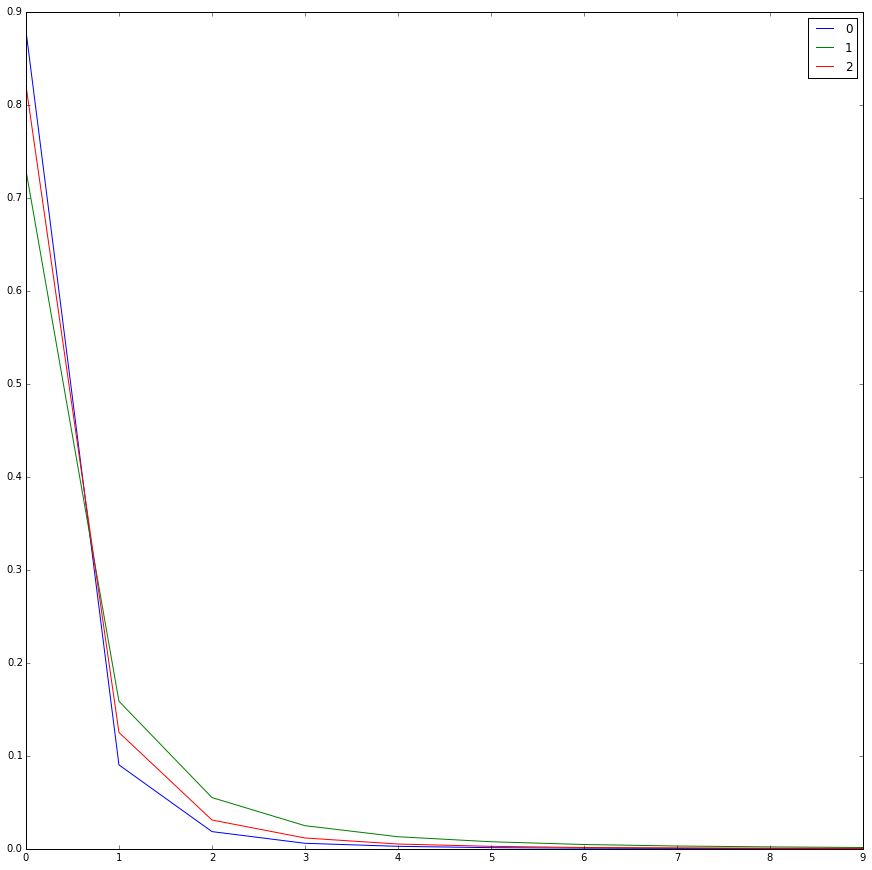

In [696]:

pd.DataFrame(cluster_handle.cluster_centers_).transpose().plot(figsize=(15,15))
#模式并不是很明显,不过单次访问的比例可以作为一个商店的特征

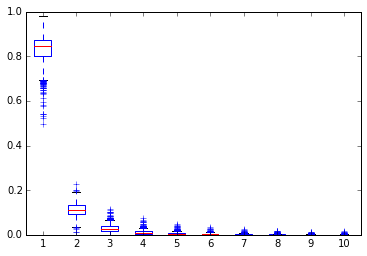

In [699]:
shop_view_cnt_user_cnt_normalized.plot(kind="box")